# I am using the cars1-2.dta Dataset

In [1]:
# load necessary packages python 
import pyblp
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# load data
data = pd.read_stata('../data/cars1-2.dta')

/opt/anaconda3/lib/python3.8/site-packages/pandas/io/stata.py:1417: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


In [3]:
data.columns

Index(['year', 'country', 'co', 'model', 'segment', 'domestic', 'firm',
       'brand', 'loc', 'qu', 'pr', 'princ', 'price', 'horsepower', 'fuel',
       'width', 'height', 'weight', 'pop', 'ngdp', 'ngdpe', 'country1',
       'country2', 'country3', 'country4', 'country5', 'yearsquared'],
      dtype='object')

In [ ]:
class blp_pset:
    """
    A class used to represent a BLP (Berry, Levinsohn, and Pakes) model.
    Attributes
    ----------
    data : any
        The data used for the BLP model.
    Methods
    -------
    """
    def __init__(self, data):
        self.data = data
        

    def return_data(self):
        return self.data
    
    def define_market_share(self,market_share_assumption):
        # market share assumption
        # i will just assume total market share is a multiple of sales        
        # for each loc and year
        # first find total sale by adding up the qu
        
        data_copy = self.data.copy()
        data_copy['total_sales'] = data_copy.groupby(['country', 'year'])['qu'].transform('sum')
        # then calculate market share
        data_copy['market_share'] = data_copy['qu'] / (data_copy['total_sales'] * market_share_assumption)
        # then drop total_sales
        data_copy.drop(columns=['total_sales'], inplace=True)
        # define a outside share column
        data_copy['outside_share'] = 1 - data_copy.groupby(['country', 'year'])['market_share'].transform('sum')
        return data_copy
    
    def set_up_variables(self,dataset):
        # rename columns
        # market_ids = for each loc and year
        dataset['market_ids'] = dataset['country'].astype(str) + '_' + dataset['year'].astype(str)
        # product_ids = model
        dataset['product_ids'] = dataset['model']
        # shares =  market_share
        dataset['shares'] = dataset['market_share']
        # prices --> price
        dataset['prices'] = dataset['price']
        # firm_ids
        dataset['firm_ids'] = dataset['brand']

        return dataset
    
    def create_instruments(self,dataset,exo_char,instrument):
        # this function creates instruments
        if instrument == 'own':
            dataset['demand_instruments0'] = dataset['prices']
            
        elif instrument == 'hausman':
            #calulate the average price of a model in all other markets
            # hausman = (total sales - own market sales)/(total quantity - own quantity)
            # should not use hausman instrument with C(market_ids) + C(product_ids) as within a market there is no first stage
            dataset['demand_instruments0'] = (dataset.groupby(['model','year'])['prices'].transform('sum') - dataset['prices'])/(dataset.groupby(['model','year'])['prices'].transform('count')-1)
            # check if demand_instruments has any missing or nan or infinities
            if dataset['demand_instruments0'].isnull().any() or not np.isfinite(dataset['demand_instruments0']).all():
                print("demand_instruments0 contains missing values, NaNs or infinities.")
                # keep only rows with missing or nan or infinities in demand_instruments0
                print(f'orginal shape {dataset.shape}')
                dataset = dataset[~((dataset['demand_instruments0'].isnull()) | (~np.isfinite(dataset['demand_instruments0'])))]
                print(f'after dropping missing or nan or infinities shape {dataset.shape}')
                
            
        elif instrument == 'blp':
            for i,char in enumerate(exo_char):
                # leave out mean = (total char - own char)/(total quantity - own quantity)
                dataset[f'demand_instruments{i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)
                # check if demand_instruments0 has any missing or nan or infinities
                if dataset[f'demand_instruments{i}'].isnull().any() or not np.isfinite(dataset[f'demand_instruments{i}']).all():
                    print(f"demand_instruments{i} contains missing values, NaNs or infinities.")
                    # keep only rows with missing or nan or infinities in demand_instruments0
                    print(f'orginal shape {dataset.shape}')
                    dataset = dataset[~((dataset[f'demand_instruments{i}'].isnull()) | (~np.isfinite(dataset[f'demand_instruments{i}'])))]
                    print(f'after dropping missing or nan or infinities shape {dataset.shape}')

        
        elif instrument == 'nest_size':
            # find the biggest integer subscript for demand_instruments
            sub_list = [int(c.replace('demand_instruments','')) for c in dataset.columns if 'demand_instruments' in c]
            next = max(sub_list)+1
            dataset[f'demand_instruments{next}'] = dataset.groupby(['market_ids','nesting_ids'])['shares'].transform(np.size)
        
        elif instrument == 'nest_other_char':
            # find the biggest integer subscript for demand_instruments
            sub_list = [int(c.replace('demand_instruments','')) for c in dataset.columns if 'demand_instruments' in c]
            next = max(sub_list)+1
            for i,char in enumerate(exo_char):
                # leave out mean = (total char - own char)/(total quantity - own quantity)
                dataset[f'demand_instruments{next+i}'] = (dataset.groupby(['market_ids','nesting_ids'])[f'{char}'].transform('sum')- dataset[f'{char}'])/((dataset.groupby(['market_ids','nesting_ids'])[f'{char}'].transform('count')-1))
                # check if demand_instruments0 has any missing or nan or infinities
                if dataset[f'demand_instruments{next+i}'].isnull().any() or not np.isfinite(dataset[f'demand_instruments{next+i}']).all():
                    print(f"demand_instruments{next+i} contains missing values, NaNs or infinities.")
                    # keep only rows with missing or nan or infinities in demand_instruments0
                    print(f'orginal shape {dataset.shape}')
                    dataset = dataset[~((dataset[f'demand_instruments{next+i}'].isnull()) | (~np.isfinite(dataset[f'demand_instruments{next+i}'])))]
                    print(f'after dropping missing or nan or infinities shape {dataset.shape}')
                # check if demand_instruments has any variation - if not drop it
                if dataset[f'demand_instruments{next+i}'].nunique() == 1:
                    print(f'no variation in demand_instruments{next+i}')
                    dataset.drop(columns=[f'demand_instruments{next+i}'], inplace=True)
        
        elif instrument == 'nest_both':
            dataset = self.create_instruments(dataset,exo_char,'nest_size')
            dataset = self.create_instruments(dataset,exo_char,'nest_other_char')
        
        return dataset
        
    def run_logit(self,market_share_assumption,instrument,FE):
        # take as input market_share_assumption
        print(f'market share assumption is {market_share_assumption}')
        logit_data = self.define_market_share(market_share_assumption)
        # run logit and return results
        
        # rename columns
        logit_data = self.set_up_variables(logit_data)
        
        # define an instrument for prices
        print(f'instrument type is {instrument}')
        # define exogenous list of characteristics
        exo_char = ['domestic','horsepower','fuel','width', 'height', 'weight']
        logit_data = self.create_instruments(logit_data,exo_char,instrument)
                        
        # define an FE type
        print(f'FE type is {FE}')
        
        if FE == 'none':
            FE_list = []
        elif FE == 'product_ids':
            FE_list = ['product_ids']
        elif FE == 'market_ids':
            FE_list = ['market_ids']
        elif FE == 'product_ids+market_ids':
            FE_list = ['product_ids','market_ids']
            
        # define formulation

        reg_formulation = '+'.join(['1','prices']+exo_char)
        fe_formulation = '+'.join([f'C({d})' for d in FE_list])
        # define logit problem
        logit_problem = pyblp.Problem(pyblp.Formulation(reg_formulation, 
                                                        absorb=fe_formulation), logit_data)
        
        logit_result = logit_problem.solve(method='2s',
                                      optimization = pyblp.Optimization('trust-constr'))
        
        return logit_result,logit_data
    
    def run_logit_excercise(self):
        # run all combinations of FE, IV, Market Share choice
        # report price coef
        result_dictionary = {}
        beta_estimates = []
        #for FE in ['none','product_ids','market_ids','product_ids+market_ids']:
        for FE in ['product_ids+market_ids']:
            #for IV in ['own','hausman','blp']:
            for IV in ['blp']:
                #for market_share_assumption in [1.1,1.2,1.5]:
                for market_share_assumption in [1.1,5,10]:
                    spec_name = f'FE={FE}, IV={IV}, Market Share Assumption={market_share_assumption}'
                    logit_result = self.run_logit(market_share_assumption,IV,FE)
                    result_dictionary[spec_name] = logit_result
                    beta_dict = dict(zip(logit_result[0].beta_labels, logit_result[0].beta))
                    beta_se_dict = dict(zip(logit_result[0].beta_labels, logit_result[0].beta_se))
                    
                    beta_estimates.append((FE,IV,market_share_assumption, beta_dict['prices'][0], beta_se_dict['prices'][0]))
                    
                    
                    #compute elasticity
                    #report Belgium_1990
                    result_dictionary[spec_name] = result_dictionary[spec_name][0],result_dictionary[spec_name][1],logit_result[0].compute_elasticities(market_id='Belgium_1990')     
        
        beta_estimates = pd.DataFrame(beta_estimates,columns = ['FE','IV','Market Share Assumption','Price Beta','Beta SE'])
        
        # identify the top 10 most expensive cars in the Belgium_1990 market
        # full FE + blp iv result
        preferred_result = result_dictionary['FE=product_ids+market_ids, IV=blp, Market Share Assumption=1.1']
        # identify the top 10 most expensive cars in the Belgium_1990 market
        Belgium_1990_top10_data = preferred_result[1].sort_values('prices')[:10]
        # first create a 100 X 100 matrix where each column is -1*beta*price_i*share_i
        # reshape to (10,10)
        elasticity_matrix = -1*preferred_result[0].beta[0]*np.tile((Belgium_1990_top10_data[['shares']].values * Belgium_1990_top10_data[['prices']].values).T,(10,1))
        # replace the diagonal with the own price elasticities
        np.fill_diagonal(elasticity_matrix, preferred_result[0].beta[0] * Belgium_1990_top10_data['prices'].values * (1 - Belgium_1990_top10_data['shares'].values))
        # the i,j-th entry is the elasticity of i wrt to j
        
        return result_dictionary,beta_estimates,elasticity_matrix
    
    def run_nested_logit(self,market_share_assumption,instrument,FE,nest,nest_instrument):
        # take as input market_share_assumption
        print(f'market share assumption is {market_share_assumption}')
        nlogit_data = self.define_market_share(market_share_assumption)
        # run logit and return results
        
        # rename columns
        nlogit_data = self.set_up_variables(nlogit_data)
        
        
        # define an instrument for prices
        print(f'instrument type is {instrument}')
        # define exogenous list of characteristics
        exo_char = ['domestic','horsepower','fuel','width', 'height', 'weight']
        nlogit_data = self.create_instruments(nlogit_data,exo_char,instrument)
        
        # define nest
        nlogit_data['brand_segment'] = nlogit_data['brand'].astype(str) + '_' + nlogit_data['segment'].astype(str)
        nlogit_data['nesting_ids'] = nlogit_data[nest]
        # define nest instrument
        nlogit_data = self.create_instruments(nlogit_data,exo_char,nest_instrument)
                        
        # define an FE type
        print(f'FE type is {FE}')
        
        
        if FE == 'none':
            FE_list = []
        elif FE == 'product_ids':
            FE_list = ['product_ids']
        elif FE == 'market_ids':
            FE_list = ['market_ids']
        elif FE == 'product_ids+market_ids':
            FE_list = ['product_ids','market_ids']
            
        # define formulation

        reg_formulation = '+'.join(['1','prices']+exo_char)
        fe_formulation = '+'.join([f'C({d})' for d in FE_list])
        # define logit problem
        nlogit_problem = pyblp.Problem(pyblp.Formulation(reg_formulation, 
                                                        absorb=fe_formulation), nlogit_data)
        
        nlogit_result = nlogit_problem.solve(method='2s',optimization = pyblp.Optimization('trust-constr'),rho=0.5)
        
        return nlogit_result,nlogit_data
    
    def run_nlogit_excercise(self):
        # run all combinations of FE, IV, Market Share choice
        # report price coef
        result_dictionary = {}
        beta_estimates = []
        for FE in ['product_ids+market_ids']:
        #for FE in ['product_ids+market_ids']:
            for IV in ['blp']:
                #for IV in ['own','blp']:
                for market_share_assumption in [1.1]:
                    #for market_share_assumption in [1.1]:
                    #for nest in ['brand']:
                    for nest in ['brand','segment','brand_segment']:
                        #for nest_instrument in ['nest_other_char']:
                        for nest_instrument in ['nest_size','nest_other_char','nest_both']:
                
                            spec_name = f'FE={FE}, IV={IV}, nest={nest}, nest_instrument={nest_instrument}, Market Share Assumption={market_share_assumption}'
                            nlogit_result = self.run_nested_logit(market_share_assumption,IV,FE,nest,nest_instrument)
                            result_dictionary[spec_name] = nlogit_result
                            beta_dict = dict(zip(nlogit_result[0].beta_labels, nlogit_result[0].beta))
                            beta_se_dict = dict(zip(nlogit_result[0].beta_labels, nlogit_result[0].beta_se))
                    
                            beta_estimates.append((FE,IV,market_share_assumption,nest,nest_instrument, 
                                                   beta_dict['prices'][0], 
                                                   beta_se_dict['prices'][0],
                                                   nlogit_result[0].rho[0][0],
                                                   nlogit_result[0].rho_se[0][0]))
                    
                    
                            #compute cost
                            result_dictionary[spec_name][1]['mc'] = nlogit_result[0].compute_costs()
                            #report Belgium_1990
                            result_dictionary[spec_name] = (result_dictionary[spec_name][0],
                                                            result_dictionary[spec_name][1],
                                                            nlogit_result[0].compute_elasticities(market_id='Belgium_1990'))   
        
        beta_estimates = pd.DataFrame(beta_estimates,columns = ['FE','IV','Market Share Assumption','nest','nest_instrument','Price Beta','Beta SE','Rho','Rho SE'])
        preferred_result = result_dictionary['FE=product_ids+market_ids, IV=blp, nest=segment, nest_instrument=nest_both, Market Share Assumption=1.1']
        
        #preferred_result
        derivative_matrix_dict = {}
        elasticity_matrix_dict = {}
        for market in ['Belgium_1990','Italy_1990']:
            preferred_result_data = preferred_result[1][(preferred_result[1].market_ids == market)&
                                                    ((preferred_result[1].brand == 'Renault')|(preferred_result[1].brand == 'Fiat'))][['brand','model','price','shares']]
            preferred_result_data['group_share'] = preferred_result_data.groupby('brand')['shares'].transform('sum')
            preferred_result_data['within_share'] = preferred_result_data['shares']/preferred_result_data['group_share']
            preferred_result_data = preferred_result_data.sort_values(['brand','model'])
            preferred_result_data_i = preferred_result_data.copy()
            preferred_result_data_i.columns = [c+'_i' for c in preferred_result_data.columns]
            preferred_result_data_j = preferred_result_data.copy()
            preferred_result_data_j.columns = [c+'_j' for c in preferred_result_data.columns]
            preferred_result_data_cross = preferred_result_data_i.join(preferred_result_data_j,how='cross')
            
            rho = preferred_result[0].rho[0][0]
            beta = preferred_result[0].beta[0][0]
            # own price elasticity
            same_brand_same_model = (preferred_result_data_cross.brand_i==preferred_result_data_cross.brand_j)&(preferred_result_data_cross.model_i==preferred_result_data_cross.model_j)
            preferred_result_data_cross.loc[same_brand_same_model, 'derivative'] = (
                1 / (1 - rho) 
                * preferred_result_data_cross.loc[same_brand_same_model, 'shares_j'] 
                * (
                    1 - rho * preferred_result_data_cross.loc[same_brand_same_model, 'within_share_j'] 
                    - (1 - rho) * preferred_result_data_cross.loc[same_brand_same_model, 'shares_j']
                )
                )
            # cross price elasticity - same nest
            same_brand_diff_model = (preferred_result_data_cross.brand_i==preferred_result_data_cross.brand_j)&(preferred_result_data_cross.model_i!=preferred_result_data_cross.model_j)
            preferred_result_data_cross.loc[same_brand_diff_model, 'derivative'] = (
                -1 
                * preferred_result_data_cross.loc[same_brand_diff_model, 'shares_j'] 
                * preferred_result_data_cross.loc[same_brand_diff_model, 'shares_i']
                * ( 1 + rho/(1-rho))/ preferred_result_data_cross.loc[same_brand_diff_model, 'group_share_i']
                
                )
            # cross price elasticity - diff nest
            diff_brand_diff_model = (preferred_result_data_cross.brand_i!=preferred_result_data_cross.brand_j)&(preferred_result_data_cross.model_i!=preferred_result_data_cross.model_j)
            preferred_result_data_cross.loc[diff_brand_diff_model, 'derivative'] = (
                -1 
                * preferred_result_data_cross.loc[diff_brand_diff_model, 'shares_j'] 
                * preferred_result_data_cross.loc[diff_brand_diff_model, 'shares_i']
                )
            # pivot to get the derivative matrix where the i,j-th entry is the derivative of i wrt to j
            derivative_matrix_dict[market] = preferred_result_data_cross.pivot(index='model_i', columns='model_j', values='derivative')
            # multiply to get elasticities
            elasticity_matrix_dict[market] = (derivative_matrix_dict[market]
                                              * beta 
                                              * preferred_result_data['price'].values.reshape(-1,1).T
                                              / preferred_result_data['shares'].values.reshape(-1,1)
                                            )
        
        return result_dictionary,beta_estimates,derivative_matrix_dict,elasticity_matrix_dict
        


# Question 1

In [5]:
pset = blp_pset(data)

In [6]:
result = pset.run_logit_excercise()

market share assumption is 1.1
instrument type is blp
demand_instruments0 contains missing values, NaNs or infinities.
orginal shape (11483, 35)
after dropping missing or nan or infinities shape (11069, 35)
FE type is product_ids+market_ids
Initializing the problem ...
Absorbing demand-side fixed effects ...
Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED 
---  -----  ---  ----  ----  ----
150  11069  38    7     12    2  

Formulations:
     Column Indices:          0        1          2        3      4      5       6   
--------------------------  ------  --------  ----------  ----  -----  ------  ------
X1: Linear Characteristics  prices  domestic  horsepower  fuel  width  height  weight
Solving the problem ...
Updating the weighting matrix ...
Computed results after 00:00:00.

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix
Step      Value      Shares   Condition Number
----  -------------  -------  ----------------
 1  

In [7]:
result[1]

,FE,IV,Market Share Assumption,Price Beta,Beta SE
0,product_ids+market_ids,blp,1.1,-0.54518,0.124046
1,product_ids+market_ids,blp,5.0,-0.54518,0.124046
2,product_ids+market_ids,blp,10.0,-0.54518,0.124046


# I use both product and market id fixed effects. I use the average characteristics of the other goods in the same market as my instruments for price.
# My price coefficient is -8.882255E-02.
# My elasticity estimates for the 10 most expensive cars are as follows: the i,j-th entry is the elasticity of i wrt to the price of j

In [8]:
pd.DataFrame(result[2])

,0,1,2,3,4,5,6,7,8,9
0,-2.846809,0.168636,0.008344,0.001019,0.029233,0.000657,0.002646,0.013265,0.002367,0.001129
1,0.021234,-2.715122,0.008344,0.001019,0.029233,0.000657,0.002646,0.013265,0.002367,0.001129
2,0.021234,0.168636,-3.086514,0.001019,0.029233,0.000657,0.002646,0.013265,0.002367,0.001129
3,0.021234,0.168636,0.008344,-3.162361,0.029233,0.000657,0.002646,0.013265,0.002367,0.001129
4,0.021234,0.168636,0.008344,0.001019,-3.168567,0.000657,0.002646,0.013265,0.002367,0.001129
5,0.021234,0.168636,0.008344,0.001019,0.029233,-3.242862,0.002646,0.013265,0.002367,0.001129
6,0.021234,0.168636,0.008344,0.001019,0.029233,0.000657,-3.278075,0.013265,0.002367,0.001129
7,0.021234,0.168636,0.008344,0.001019,0.029233,0.000657,0.002646,-3.285190,0.002367,0.001129
8,0.021234,0.168636,0.008344,0.001019,0.029233,0.000657,0.002646,0.013265,-3.305704,0.001129
9,0.021234,0.168636,0.008344,0.001019,0.029233,0.000657,0.002646,0.013265,0.002367,-3.307573


# Question 2
# I use the segment as my nest. My instrument is therefore 1) the number of goods in the nest 2) the average characteristics of the other goods in the nest
# Note - rho -> 0 we have the IIA logit

In [9]:
nlogit_result = pset.run_nlogit_excercise()

market share assumption is 1.1
instrument type is blp
demand_instruments0 contains missing values, NaNs or infinities.
orginal shape (11483, 35)
after dropping missing or nan or infinities shape (11069, 35)
FE type is product_ids+market_ids
Initializing the problem ...
Absorbing demand-side fixed effects ...
Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED    H 
---  -----  ---  ----  ----  ----  ---
150  11069  38    7     13    2    38 

Formulations:
     Column Indices:          0        1          2        3      4      5       6   
--------------------------  ------  --------  ----------  ----  -----  ------  ------
X1: Linear Characteristics  prices  domestic  horsepower  fuel  width  height  weight
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+5.000000E-01

Rho Lower Bounds:
 All Groups  
-------------
+0.000000E+00

Rho Upper Bounds:
 All Groups  
-------------
+9.900000E-01

Starting optimization ...

GMM   Comp

# Preferred Specification is product_id and market_id FE, blp instrument for price,	brand as the nest, other characteristics in the nest for my instrument for within nest shares.

In [10]:
nlogit_result[1]

,FE,IV,Market Share Assumption,nest,nest_instrument,Price Beta,Beta SE,Rho,Rho SE
0,product_ids+market_ids,blp,1.1,brand,nest_size,-0.435931,0.123517,0.000036,0.079459
1,product_ids+market_ids,blp,1.1,brand,nest_other_char,-0.027844,0.043357,0.989931,0.043766
2,product_ids+market_ids,blp,1.1,brand,nest_both,0.027521,0.051941,0.397289,0.037271
3,product_ids+market_ids,blp,1.1,segment,nest_size,0.492595,0.125088,0.967806,0.155529
4,product_ids+market_ids,blp,1.1,segment,nest_other_char,-0.286141,0.021842,0.667192,0.051182
5,product_ids+market_ids,blp,1.1,segment,nest_both,-0.151032,0.018358,0.212597,0.045600
6,product_ids+market_ids,blp,1.1,brand_segment,nest_size,-0.431400,0.111856,0.151839,0.064235
7,product_ids+market_ids,blp,1.1,brand_segment,nest_other_char,-0.347539,0.094333,0.670921,0.102935
8,product_ids+market_ids,blp,1.1,brand_segment,nest_both,-0.276875,0.079605,0.447523,0.079330


# elasticity calculation
# see https://www.nathanhmiller.org/nlnotes.pdf


The derivative of product $j$'s share, for $j \in \mathcal{J}_g$, with respect to its own mean valuation is given by
$$
\begin{equation}
\frac{\partial s_j}{\partial \delta_j} = \frac{1}{1 - \sigma} s_j \left(1 - \sigma \bar{s}_j|_g - (1 - \sigma) s_j \right).
\end{equation}
$$
The derivative of product $j$'s share with respect to product $k$'s mean valuation, for $j$ and $k$ both in group $g$, equals
$$
\begin{equation}
\frac{\partial s_j}{\partial \delta_k} = -s_k \left( s_j + \frac{\sigma}{1 - \sigma} \bar{s}_j|_g \right).
\end{equation}
$$
The above formulation is correct but more difficult to use in obtaining cross-cross second derivatives because the symmetry between $j$ and $k$ isn't transparent. More helpful for those is the equivalent expression
$$
\begin{equation}
\frac{\partial s_j}{\partial \delta_k} = -s_k s_j \left( 1 + \frac{\sigma}{1 - \sigma} \frac{1}{\bar{s}_g} \right).
\end{equation}
$$
The derivative of product $j$'s share with respect to product $k$'s mean valuation, for $j$ and $k$ in different groups, equals
$$
\begin{equation}
\frac{\partial s_j}{\partial \delta_k} = -s_j s_k.
\end{equation}
$$
# The Matrix is as follows
# We now allow different substitution elasticities between cars of the different brands.
# Within brand subsitution is more flexible.
# Italy is more elastic in general. Also in Italy, there is more within brand elasticity in Fiat.
# The ratio of the cross brand elasticities are similar.

In [11]:
nlogit_result[-1]['Belgium_1990']

model_j,fiat 126,fiat croma,fiat panda,fiat regata,fiat tempra,fiat tipo,fiat uno,renault 19,renault 21,renault 25,renault 4,renault 5
model_i,,,,,,,,,,,,
fiat 126,-1.169100,0.265876,0.146245,0.01062,0.131935,0.799201,0.719954,0.079839,0.046717,0.035304,0.002107,0.038365
fiat croma,0.014226,-3.346773,0.146245,0.01062,0.131935,0.799201,0.719954,0.079839,0.046717,0.035304,0.002107,0.038365
fiat panda,0.014226,0.265876,-1.357988,0.01062,0.131935,0.799201,0.719954,0.079839,0.046717,0.035304,0.002107,0.038365
fiat regata,0.014226,0.265876,0.146245,-2.52336,0.131935,0.799201,0.719954,0.079839,0.046717,0.035304,0.002107,0.038365
fiat tempra,0.014226,0.265876,0.146245,0.01062,-2.748975,0.799201,0.719954,0.079839,0.046717,0.035304,0.002107,0.038365
fiat tipo,0.014226,0.265876,0.146245,0.01062,0.131935,-2.281353,0.719954,0.079839,0.046717,0.035304,0.002107,0.038365
fiat uno,0.014226,0.265876,0.146245,0.01062,0.131935,0.799201,-1.502317,0.079839,0.046717,0.035304,0.002107,0.038365
renault 19,0.000374,0.006998,0.003850,0.00028,0.003473,0.021037,0.018951,-2.129618,0.603563,0.456106,0.027217,0.495653
renault 21,0.000374,0.006998,0.003850,0.00028,0.003473,0.021037,0.018951,1.031487,-2.971452,0.456106,0.027217,0.495653


In [12]:
nlogit_result[-1]['Italy_1990']

model_j,fiat 126,fiat croma,fiat panda,fiat regata,fiat tempra,fiat tipo,fiat uno,renault 19,renault 21,renault 25,renault 4,renault 5
model_i,,,,,,,,,,,,
fiat 126,-1.110818,0.090022,0.290851,0.002523,0.192168,0.607400,0.716032,0.037797,0.017333,0.002460,0.004625,0.028215
fiat croma,0.028973,-3.725840,0.290851,0.002523,0.192168,0.607400,0.716032,0.037797,0.017333,0.002460,0.004625,0.028215
fiat panda,0.028973,0.090022,-1.228501,0.002523,0.192168,0.607400,0.716032,0.037797,0.017333,0.002460,0.004625,0.028215
fiat regata,0.028973,0.090022,0.290851,-2.549006,0.192168,0.607400,0.716032,0.037797,0.017333,0.002460,0.004625,0.028215
fiat tempra,0.028973,0.090022,0.290851,0.002523,-2.678693,0.607400,0.716032,0.037797,0.017333,0.002460,0.004625,0.028215
fiat tipo,0.028973,0.090022,0.290851,0.002523,0.192168,-2.234402,0.716032,0.037797,0.017333,0.002460,0.004625,0.028215
fiat uno,0.028973,0.090022,0.290851,0.002523,0.192168,0.607400,-1.319518,0.037797,0.017333,0.002460,0.004625,0.028215
renault 19,0.008099,0.025163,0.081300,0.000705,0.053715,0.169783,0.200148,-2.168473,0.447716,0.063538,0.119464,0.728794
renault 21,0.008099,0.025163,0.081300,0.000705,0.053715,0.169783,0.200148,0.976293,-3.172086,0.063538,0.119464,0.728794


# Backing out the marginal cost


In [16]:
data_with_cost = nlogit_result[0]['FE=product_ids+market_ids, IV=blp, nest=segment, nest_instrument=nest_both, Market Share Assumption=1.1'][1]

In [19]:
data_with_cost['markup'] = (data_with_cost.prices-data_with_cost.mc)/data_with_cost.prices

<AxesSubplot:>

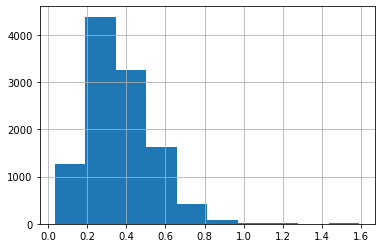

In [20]:
data_with_cost['markup'].hist()